# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
path = os.path.join('download', 'expression-matrix.pkl')
X = pd.read_pickle(path)

In [5]:
path = os.path.join('download', 'mutation-matrix.pkl')
Y = pd.read_pickle(path)

In [6]:
y = Y[GENE]

In [7]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [8]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [9]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,468 features, 6,575 training samples, 731 testing samples'

## Median absolute deviation feature selection

In [10]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [11]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'select__k': [2000],
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('select', SelectKBest(fs_mad)),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

In [12]:
%%time
cv_pipeline.fit(X=X_train, y=y_train)

CPU times: user 1min 23s, sys: 964 ms, total: 1min 24s
Wall time: 1min 41s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('select', SelectKBest(k=10, score_func=<function fs_mad at 0x7f9dc045f620>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'select__k': [2000], 'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.01, 0.1, 1], 'classify__l1_ratio': [0, 0.2, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [13]:
# Best Params
print('{:.3%}'.format(cv_pipeline.best_score_))

# Best Params
cv_pipeline.best_params_

91.733%


{'classify__alpha': 0.1,
 'classify__l1_ratio': 0,
 'classify__loss': 'log',
 'classify__penalty': 'elasticnet',
 'select__k': 2000}

## Visualize hyperparameters performance

In [14]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_select__k,params,...,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,select__k
0,3.836915,0.250220,0.889526,0.953224,0.001,0,log,elasticnet,2000,"{'classify__alpha': 0.001, 'classify__l1_ratio...",...,0.950631,0.320025,0.027849,0.001133,0.003784,0.001,0.0,log,elasticnet,2000
1,4.565614,0.161691,0.901459,0.966048,0.001,0.2,log,elasticnet,2000,"{'classify__alpha': 0.001, 'classify__l1_ratio...",...,0.963435,0.208000,0.029836,0.003076,0.001900,0.001,0.2,log,elasticnet,2000


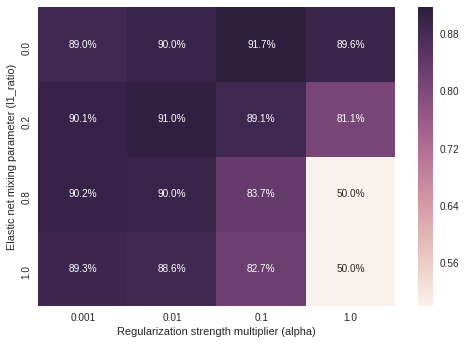

In [15]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [16]:
y_pred_train = cv_pipeline.decision_function(X_train)
y_pred_test = cv_pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

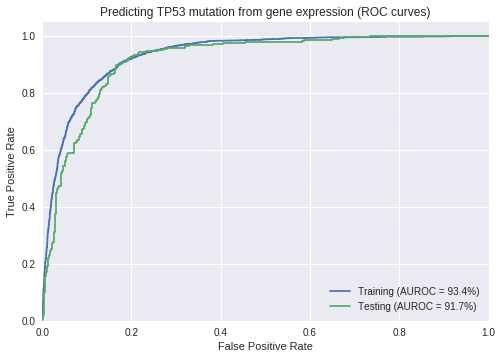

In [17]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [18]:
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

In [19]:
select_indices = final_pipeline.named_steps['select'].transform(
    np.arange(len(X.columns)).reshape(1, -1)
).tolist()

coef_df = pd.DataFrame.from_items([
    ('feature', X.columns[select_indices]),
    ('weight', final_classifier.coef_[0]),
])

coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [20]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'0.0% zero coefficients; 948 negative and 1,052 positive coefficients'

In [21]:
coef_df.head(10)

,feature,weight,abs
1351,60401,-0.434611,0.434611
901,9518,-0.176995,0.176995
120,1029,0.153476,0.153476
1223,55065,-0.153214,0.153214
1285,56164,0.116904,0.116904
1463,80704,0.110387,0.110387
996,11065,0.104764,0.104764
1503,84417,-0.103460,0.103460
1843,283417,-0.102404,0.102404
832,8744,-0.099632,0.099632


## Investigate the predictions

In [22]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', cv_pipeline.decision_function(X)),
    ('probability', cv_pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [23]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,4.832659,0.992098,99.2%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,4.792348,0.991775,99.2%
TCGA-09-2051-01,TCGA-09-2051-01,0,0,4.600631,0.990054,99.0%
TCGA-B6-A0I6-01,TCGA-B6-A0I6-01,1,0,4.454604,0.988509,98.9%
TCGA-55-6981-01,TCGA-55-6981-01,0,0,4.104939,0.983777,98.4%
TCGA-L5-A4OO-01,TCGA-L5-A4OO-01,0,0,4.069395,0.983199,98.3%
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,4.001662,0.982043,98.2%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,3.924997,0.980640,98.1%
TCGA-55-6982-01,TCGA-55-6982-01,0,0,3.903367,0.980225,98.0%


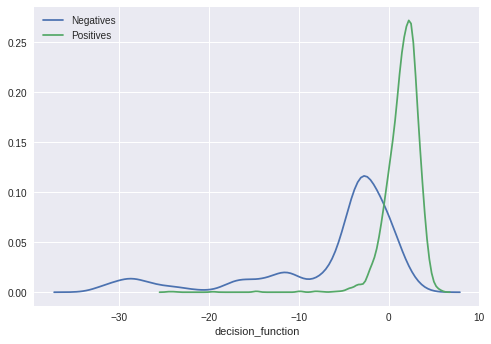

In [24]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

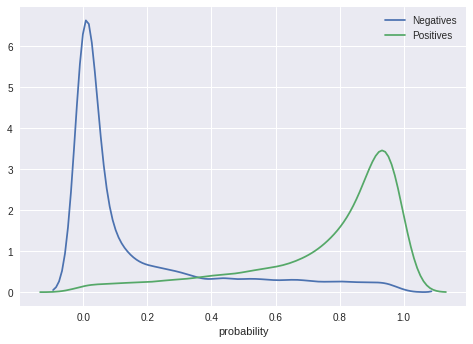

In [25]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')